In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2  # OpenCV
from tqdm import tqdm 
import random
from fastai.vision.all import *
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd

# Read the CSV file
data = pd.read_csv("Data_Entry_2017.csv")

# Select only the columns "Image Index" and "Finding Labels"
selected_columns = data[["Image Index", "Finding Labels"]]

df = selected_columns

In [3]:
df

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


In [4]:
# Define the list of allowed labels
allowed_labels = ["Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
                  "Mass", "Nodule", "Pneumonia", "Pneumothorax",
                  "Consolidation", "No Finding"]

# Filter rows based on the condition
filtered_df = df[df['Finding Labels'].isin(allowed_labels)]

# Display the filtered DataFrame
print(filtered_df)

             Image Index Finding Labels
0       00000001_000.png   Cardiomegaly
3       00000002_000.png     No Finding
13      00000005_000.png     No Finding
14      00000005_001.png     No Finding
15      00000005_002.png     No Finding
...                  ...            ...
112114  00030801_000.png     No Finding
112116  00030802_000.png     No Finding
112117  00030803_000.png     No Finding
112118  00030804_000.png     No Finding
112119  00030805_000.png     No Finding

[87841 rows x 2 columns]


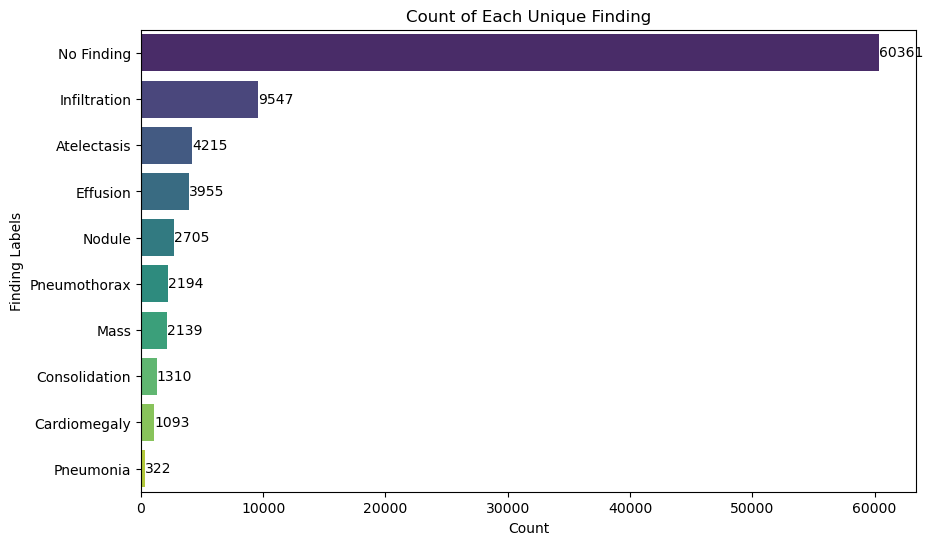

In [5]:
# Count the occurrences of each unique finding
finding_counts = filtered_df['Finding Labels'].value_counts()

# Plot the count of each unique finding
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=finding_counts.values, y=finding_counts.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Finding Labels')
plt.title('Count of Each Unique Finding')

# Annotate each bar with its count
for i, count in enumerate(finding_counts.values):
    ax.text(count, i, str(count), va='center')

plt.show()

In [6]:
# Group the DataFrame by 'Finding Labels' and sample 1000 rows from each group
sampled_df = filtered_df.groupby('Finding Labels', group_keys=False).apply(lambda x: x.sample(min(len(x), 3000), random_state=42))

# Check the total number of rows
total_rows = len(sampled_df)

# Shuffle the DataFrame
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the sampled DataFrame
print(sampled_df)

            Image Index Finding Labels
0      00006111_001.png     No Finding
1      00001046_000.png   Infiltration
2      00021706_003.png    Atelectasis
3      00014919_012.png    Atelectasis
4      00020810_001.png     No Finding
...                 ...            ...
21758  00027893_003.png           Mass
21759  00001951_015.png   Pneumothorax
21760  00017691_006.png  Consolidation
21761  00016358_012.png    Atelectasis
21762  00014082_012.png     No Finding

[21763 rows x 2 columns]


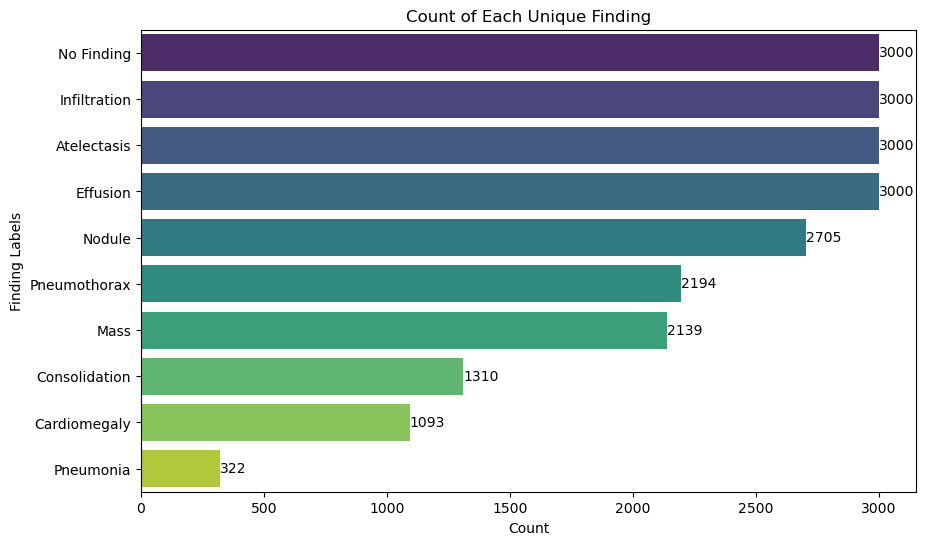

In [7]:
# Count the occurrences of each unique finding
finding_counts = sampled_df['Finding Labels'].value_counts()

# Plot the count of each unique finding
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=finding_counts.values, y=finding_counts.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Finding Labels')
plt.title('Count of Each Unique Finding')

# Annotate each bar with its count
for i, count in enumerate(finding_counts.values):
    ax.text(count, i, str(count), va='center')

plt.show()

In [8]:
sampled_df

,Image Index,Finding Labels
0,00006111_001.png,No Finding
1,00001046_000.png,Infiltration
2,00021706_003.png,Atelectasis
3,00014919_012.png,Atelectasis
4,00020810_001.png,No Finding
...,...,...
21758,00027893_003.png,Mass
21759,00001951_015.png,Pneumothorax
21760,00017691_006.png,Consolidation
21761,00016358_012.png,Atelectasis


In [9]:
# Define the path to the folder containing images
data_folder = "Data"
image_folders = ["images_001", "images_002", "images_003", "images_004", "images_005",
                 "images_006", "images_007", "images_008", "images_009", "images_010",
                 "images_011", "images_012"]

# Function to load images and labels
def load_images_and_labels(df, data_folder, image_folders):
    images = []
    labels = []
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Loading Images"):
        image_name = row["Image Index"]
        label = row["Finding Labels"]
        # Find the appropriate folder for the image
        for folder in image_folders:
            image_path = os.path.join(data_folder, folder, image_name)
            if os.path.exists(image_path):
                # Load the image using OpenCV (you can also use PIL)
                image = cv2.imread(image_path)
                images.append(image)
                labels.append(label)
                break
    return images, labels

# Load images and labels
images, labels = load_images_and_labels(sampled_df, data_folder, image_folders)

# Display the number of loaded images
print("Number of loaded images:", len(images))

Loading Images: 100%|██████████| 21763/21763 [04:49<00:00, 75.09it/s]

Number of loaded images: 21763


In [11]:
# Define a function to get the image path
def get_image_path(image_name, data_folder, image_folders):
    for folder in image_folders:
        image_path = os.path.join(data_folder, folder, image_name)
        if os.path.exists(image_path):
            return image_path

# Define a function to get the label for an image
def get_label(image_name, df):
    return df[df['Image Index'] == image_name]['Finding Labels'].values[0]

# Define a function to get the data
def get_data(df, data_folder, image_folders):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=lambda x: df['Image Index'],
        get_y=lambda x: get_label(x, df),
        splitter=RandomSplitter(valid_pct=0.15, seed=42),
        get_x=lambda x: get_image_path(x, data_folder, image_folders),
        item_tfms=Resize(320),
        batch_tfms=[Normalize.from_stats(mean=[0.0000], std=[1.0000])]
    ).dataloaders(df, bs=16)

# Load the data
dls = get_data(sampled_df, data_folder, image_folders)

epoch,train_loss,valid_loss,accuracy,time
0,2.304234,2.139610,0.244179,25:10


epoch,train_loss,valid_loss,accuracy,time
0,1.964631,1.906511,0.323836,32:32
1,1.763903,1.723521,0.394301,32:28
2,1.474635,1.681492,0.422488,32:23


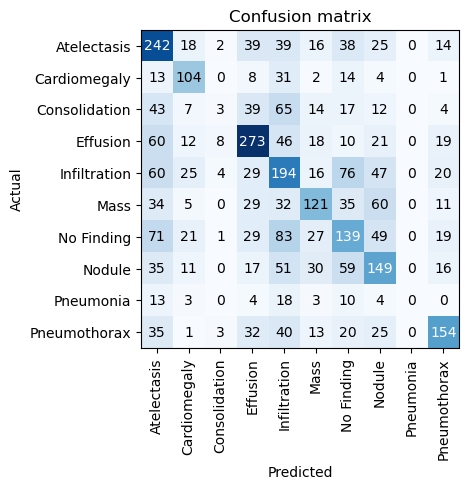

In [12]:
# Choose ResNet model
learn = vision_learner(dls, resnet34, metrics=accuracy)

# Train the model
learn.fine_tune(3)

# Evaluate the model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
import pickle

# Save the model
with open('x_ray_pred.pkl', 'wb') as f:
    pickle.dump(learn.model.state_dict(), f)

In [1]:
pip install pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
